# AIFFEL 네 번째 프로젝트 : 영화리뷰 감성분석
## 1.1 네이버 영화 댓글 데이터 준비
- 터미널을 통해 네이버 영화 평점 사이트에서 데이터를 다운로드한다.
```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification
```

### 1.1.1. 데이터 분석 패키지 import

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

### 1.1.2. 데이터 읽기

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 1.2 데이터로더 구성
- 실습때 다루었던 IMDB 데이터셋은 숫자 인덱스로 변환된 텍스트, word_to_index 딕셔너리까지 친절하게 제공한다. 
- 그러나 네이버 영화 데이터는 **nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일**로 이루어져 있어, imdb 데이터로더와 같은 동작하는 함수를 만들어야 한다. 만든 data_loader 안에서는 다음을 수행해야한다.
    - 데이터의 중복 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords) 제거
    - 사전word_to_index 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
# word to index > index to word로 바꾼 딕셔너리
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 1.3 모델구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가  

In [6]:
# 데이터셋 상 문장 길이 통일
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen) #580
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


- 자연어처리의 경우, 단어의 흐름이 중요하기 때문에 뒤에 패딩값을 넣는 것보다 앞에 넣는 것이 뒤에 나올 단어를 예측하기가 더 좋다.

## 1.4 모델구성 및 validation set 구성

- 모델 3가지 이상 다양하게 구성하여 실험해보기
#### LSTM 레이어 : 가장 널리 쓰이는 RNN

In [8]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16 # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# LSTM 모델 설계
lstm_model = keras.Sequential()
lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm_model.add(keras.layers.LSTM(16))
lstm_model.add(keras.layers.Dense(vocab_size, activation='relu'))
lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 10000)             170000    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 342,113
Trainable params: 342,113
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 1-D CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

cnn_model = keras.Sequential()

cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(Dropout(0.5)) # 과적합을 방지하기 위해 dropout을 추가하였다.
cnn_model.add(Conv1D(256, 7, padding='valid', activation='relu'))
cnn_model.add(MaxPooling1D(5))
cnn_model.add(Conv1D(128, 7, padding='valid', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         28928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         229504    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [10]:
maxp_model = keras.Sequential()
maxp_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
maxp_model.add(keras.layers.GlobalMaxPooling1D())
maxp_model.add(keras.layers.Dense(vocab_size, activation='relu'))
maxp_model.add(keras.layers.Dense(1, activation='sigmoid')) 
maxp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10000)             170000    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 10001     
Total params: 340,001
Trainable params: 340,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 (146182-10000)건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 1.5 모델 훈련 개시
- 과적합판단을 위해 중간 과정으로 삽입한 코드
     - 4번째에서 과적합이 판단되어 epoch를 10 이상으로 하지 않았다.
```
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)
```

In [12]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
maxp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs = 10           # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

lstm_history = lstm_model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=256, validation_data=(X_val, y_val), verbose = 1)
cnn_history = cnn_model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=256, validation_data=(X_val, y_val), verbose = 1)
maxp_history = maxp_model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=256, validation_data=(X_val, y_val), verbose = 1)

Epoch 1/10
532/532 [==============================] - 3s 5ms/step - loss: 0.3975 - accuracy: 0.8179 - val_loss: 0.3542 - val_accuracy: 0.8462
Epoch 2/10
532/532 [==============================] - 2s 4ms/step - loss: 0.3267 - accuracy: 0.8606 - val_loss: 0.3373 - val_accuracy: 0.8535
Epoch 3/10
532/532 [==============================] - 2s 4ms/step - loss: 0.3015 - accuracy: 0.8735 - val_loss: 0.3371 - val_accuracy: 0.8537
Epoch 4/10
532/532 [==============================] - 2s 4ms/step - loss: 0.2813 - accuracy: 0.8825 - val_loss: 0.3358 - val_accuracy: 0.8539
Epoch 5/10
532/532 [==============================] - 2s 4ms/step - loss: 0.2597 - accuracy: 0.8922 - val_loss: 0.3516 - val_accuracy: 0.8559
Epoch 6/10
532/532 [==============================] - 2s 4ms/step - loss: 0.2362 - accuracy: 0.9023 - val_loss: 0.3593 - val_accuracy: 0.8549
Epoch 7/10
532/532 [==============================] - 2s 4ms/step - loss: 0.2161 - accuracy: 0.9110 - val_loss: 0.4064 - val_accuracy: 0.8551
Epoch 

## 1.6 Loss, Accuracy 그래프 시각화

In [13]:
lstm_results = lstm_model.evaluate(X_test,  y_test, verbose=2)
cnn_results = cnn_model.evaluate(X_test,  y_test, verbose=2)
maxp_results = maxp_model.evaluate(X_test,  y_test, verbose=2)

print(lstm_results, cnn_results, maxp_results)

1537/1537 - 2s - loss: 0.5153 - accuracy: 0.8441
1537/1537 - 3s - loss: 0.3481 - accuracy: 0.8495
1537/1537 - 1s - loss: 0.4350 - accuracy: 0.8309
[0.5152854323387146, 0.8441117405891418] [0.3480774462223053, 0.8494619131088257] [0.4350074827671051, 0.8309294581413269]


- 세 모델 모두 loss는 0.3~0.5, 정확도는 약 84% 수준이었다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']) dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']) dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


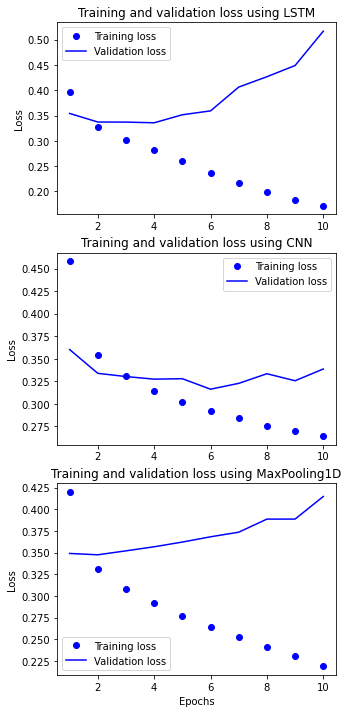

In [14]:
lstm_history_dict = lstm_history.history
cnn_history_dict = cnn_history.history
maxp_history_dict = maxp_history.history
print(lstm_history_dict.keys(),cnn_history_dict.keys(), maxp_history_dict.keys())# epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt
lstm_acc = lstm_history_dict['accuracy']
lstm_val_acc = lstm_history_dict['val_accuracy']
lstm_loss = lstm_history_dict['loss']
lstm_val_loss = lstm_history_dict['val_loss']

cnn_acc = cnn_history_dict['accuracy']
cnn_val_acc = cnn_history_dict['val_accuracy']
cnn_loss = cnn_history_dict['loss']
cnn_val_loss = cnn_history_dict['val_loss']

maxp_acc = maxp_history_dict['accuracy']
maxp_val_acc = maxp_history_dict['val_accuracy']
maxp_loss = maxp_history_dict['loss']
maxp_val_loss = maxp_history_dict['val_loss']

x_epochs = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다 # b는 "파란 실선"입니다
fig = plt.figure(figsize=(5, 12))
plt.subplot(3,1,1)
plt.plot(x_epochs, lstm_loss, 'bo', label='Training loss')
plt.plot(x_epochs, lstm_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss using LSTM')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,2)
plt.plot(x_epochs, cnn_loss, 'bo', label='Training loss')
plt.plot(x_epochs, cnn_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss using CNN')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,3)
plt.plot(x_epochs, maxp_loss, 'bo', label='Training loss')
plt.plot(x_epochs, maxp_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss using MaxPooling1D')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

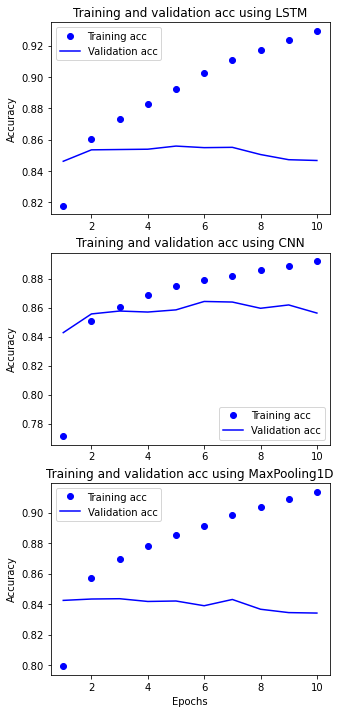

In [15]:
# 모델 별 정확도 그래프
fig = plt.figure(figsize=(5, 12))
plt.subplot(3,1,1)
plt.plot(x_epochs, lstm_acc, 'bo', label='Training acc')
plt.plot(x_epochs, lstm_val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc using LSTM')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,1,2)
plt.plot(x_epochs, cnn_acc, 'bo', label='Training acc')
plt.plot(x_epochs, cnn_val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc using CNN')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,1,3)
plt.plot(x_epochs, maxp_acc, 'bo', label='Training acc')
plt.plot(x_epochs, maxp_val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc using MaxPooling1D')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 학습 loss, acc와 검증 loss, acc의 차이가 존재해 학습 모델의 타당성을 의심하게 되었다.

## 1.7 학습된 Embedding 레이어 분석

- gensim 을 이용해 워드벡터 다뤄보기

In [18]:
embedding_layer = lstm_model.layers[0] # 임의로 레이어를 잡았다.
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [21]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [22]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path,binary=False)

## 1.8 한국어 Word2Vec 임베딩 활용하여 성능개선
[한국어 word2vec 다운링크](https://github.com/Kyubyong/wordvectors)

In [23]:
import os
from gensim.models import KeyedVectors

kor_word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko (1)/ko.vec'
kor_word2vec = KeyedVectors.load_word2vec_format(kor_word2vec_path)
kor_word2vec.similar_by_word("귀신")

[('악귀', 0.6136887073516846),
 ('악령', 0.6043179035186768),
 ('요괴', 0.5954419374465942),
 ('괴물', 0.5644373893737793),
 ('무당', 0.5481067895889282),
 ('신령', 0.5346256494522095),
 ('악마', 0.5342945456504822),
 ('천둥', 0.5210751891136169),
 ('무서워하', 0.5206892490386963),
 ('마귀', 0.5190808176994324)]

- 귀신과 관련된 단어가 나오는 것을 볼 수 있는데, 관련정도가 그렇게 높지 않다.

In [24]:
# 이전 모델의 임베딩 레이어를 word2vec로 교체해서 다시 학습
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in kor_word2vec:
        embedding_matrix[i] = kor_word2vec[index_to_word[i]]

In [25]:
from tensorflow.keras.initializers import Constant
# 앞서 구현했던 모델들에서 embedding 부분만 변경했다.

# LSTM
k_lstm_model = keras.Sequential()
k_lstm_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, trainable=True))
k_lstm_model.add(keras.layers.LSTM(16))
k_lstm_model.add(keras.layers.Dense(vocab_size, activation='relu'))
k_lstm_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

k_lstm_model.summary()

# 1-D CNN 모델 구성 
k_cnn_model = keras.Sequential()
k_cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, trainable=True))   # trainable을 True로 주면 Fine-tuning
k_cnn_model.add(Dropout(0.5))
k_cnn_model.add(Conv1D(256, 7, padding='valid', activation='relu'))
k_cnn_model.add(MaxPooling1D(5))
k_cnn_model.add(Conv1D(128, 7, padding='valid', activation='relu'))
k_cnn_model.add(GlobalMaxPooling1D())
k_cnn_model.add(Dense(64, activation='relu'))
k_cnn_model.add(Dropout(0.5))
k_cnn_model.add(Dense(1, activation='sigmoid'))

k_cnn_model.summary()

# MaxPooling1D 모델
k_maxp_model = keras.Sequential()
k_maxp_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, trainable=True))
k_maxp_model.add(GlobalMaxPooling1D())
k_maxp_model.add(Dense(vocab_size, activation='relu'))
k_maxp_model.add(Dense(1, activation='sigmoid')) 
                 
k_maxp_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_6 (Dense)              (None, 10000)             170000    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 10001     
Total params: 2,193,889
Trainable params: 2,193,889
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
______________________

In [26]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 (146182-10000)건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)
# 학습 진행

k_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
k_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
k_maxp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
              
epochs = 10           # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.

k_lstm_history = k_lstm_model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=256, validation_data=(X_val, y_val), verbose = 1)# callbacks=[es])
k_cnn_history = k_cnn_model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=256, validation_data=(X_val, y_val), verbose = 1)# callbacks=[es])
k_maxp_history = k_maxp_model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=256, validation_data=(X_val, y_val), verbose = 1)# callbacks=[es])

(136182, 41)
(136182,)
Epoch 1/10
532/532 [==============================] - 10s 19ms/step - loss: 0.4054 - accuracy: 0.8110 - val_loss: 0.3344 - val_accuracy: 0.8567
Epoch 2/10
532/532 [==============================] - 10s 18ms/step - loss: 0.3151 - accuracy: 0.8645 - val_loss: 0.3171 - val_accuracy: 0.8605
Epoch 3/10
532/532 [==============================] - 10s 18ms/step - loss: 0.2790 - accuracy: 0.8820 - val_loss: 0.3217 - val_accuracy: 0.8615
Epoch 4/10
532/532 [==============================] - 10s 18ms/step - loss: 0.2497 - accuracy: 0.8959 - val_loss: 0.3201 - val_accuracy: 0.8639
Epoch 5/10
532/532 [==============================] - 10s 18ms/step - loss: 0.2228 - accuracy: 0.9095 - val_loss: 0.3352 - val_accuracy: 0.8648
Epoch 6/10
532/532 [==============================] - 10s 18ms/step - loss: 0.1961 - accuracy: 0.9216 - val_loss: 0.3702 - val_accuracy: 0.8566
Epoch 7/10
532/532 [==============================] - 10s 18ms/step - loss: 0.1722 - accuracy: 0.9322 - val_loss:

In [27]:
# 테스트셋을 통한 세 모델 평가
k_lstm_results = k_lstm_model.evaluate(X_test,  y_test, verbose=2)
k_cnn_results = k_cnn_model.evaluate(X_test,  y_test, verbose=2)
k_maxp_results = k_maxp_model.evaluate(X_test,  y_test, verbose=2)

print(k_lstm_results, k_cnn_results, k_maxp_results)

1537/1537 - 3s - loss: 0.5404 - accuracy: 0.8505
1537/1537 - 3s - loss: 0.3504 - accuracy: 0.8609
1537/1537 - 2s - loss: 0.4866 - accuracy: 0.8237
[0.5404054522514343, 0.8505401015281677] [0.35038700699806213, 0.860874354839325] [0.48662251234054565, 0.823667049407959]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']) dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']) dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


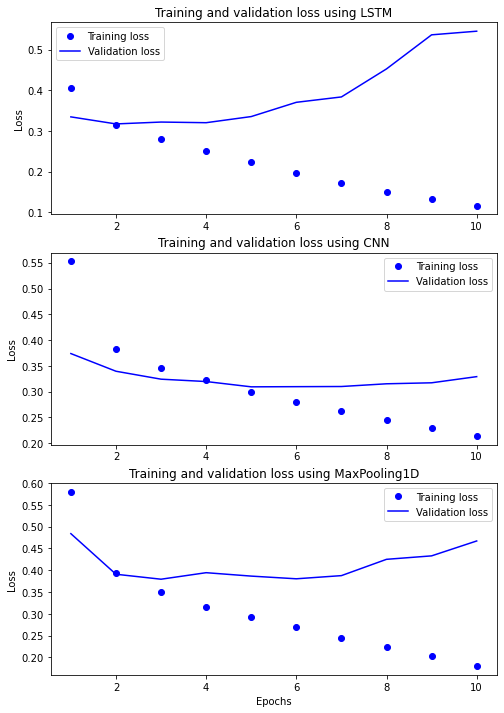

In [28]:
k_lstm_history_dict = k_lstm_history.history
k_cnn_history_dict = k_cnn_history.history
k_maxp_history_dict = k_maxp_history.history
print(k_lstm_history_dict.keys(), k_cnn_history_dict.keys(), k_maxp_history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt
k_lstm_acc = k_lstm_history_dict['accuracy']
k_lstm_val_acc = k_lstm_history_dict['val_accuracy']
k_lstm_loss = k_lstm_history_dict['loss']
k_lstm_val_loss = k_lstm_history_dict['val_loss']

k_cnn_acc = k_cnn_history_dict['accuracy']
k_cnn_val_acc = k_cnn_history_dict['val_accuracy']
k_cnn_loss = k_cnn_history_dict['loss']
k_cnn_val_loss = k_cnn_history_dict['val_loss']

k_maxp_acc = k_maxp_history_dict['accuracy']
k_maxp_val_acc = k_maxp_history_dict['val_accuracy']
k_maxp_loss = k_maxp_history_dict['loss']
k_maxp_val_loss = k_maxp_history_dict['val_loss']

x_epochs = range(1, epochs + 1)

fig = plt.figure(figsize=(8, 12))
plt.subplot(3,1,1)
plt.plot(x_epochs, k_lstm_loss, 'bo', label='Training loss')
plt.plot(x_epochs, k_lstm_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss using LSTM')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,2)
plt.plot(x_epochs, k_cnn_loss, 'bo', label='Training loss')
plt.plot(x_epochs, k_cnn_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss using CNN')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,1,3)
plt.plot(x_epochs, k_maxp_loss, 'bo', label='Training loss')
plt.plot(x_epochs, k_maxp_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss using MaxPooling1D')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

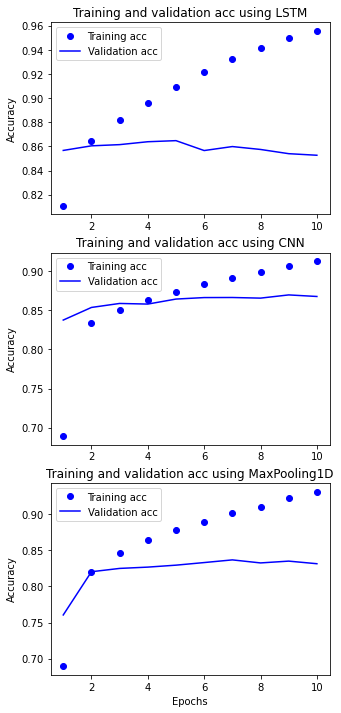

In [29]:
# word2vec 이용한 모델 별 정확도 그래프
fig = plt.figure(figsize=(5, 12))
plt.subplot(3,1,1)
plt.plot(x_epochs, k_lstm_acc, 'bo', label='Training acc')
plt.plot(x_epochs, k_lstm_val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc using LSTM')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,1,2)
plt.plot(x_epochs, k_cnn_acc, 'bo', label='Training acc')
plt.plot(x_epochs, k_cnn_val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc using CNN')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,1,3)
plt.plot(x_epochs, k_maxp_acc, 'bo', label='Training acc')
plt.plot(x_epochs, k_maxp_val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc using MaxPooling1D')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

---
## 루비닉
#### 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
#### 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
- 1, 2번은 위에 나와있다.  

#### 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
- 노드 그대로의 모델을 가져와 성능향상을 보려고 했으나, Word2Vec의 데이터로는 한계가 있다고 생각해 모델을 새로 구축해서 학습하게 되었다. 그래프를 통해 Word2Vec의 큰 성능 향상은 아니지만 1% 가량 상승한 것을 볼 수 있었다. 과적합의 문제가 있는 것으로 판단해 CNN 모델을 다시 구축했을 때, dropout을 이용하여 어느 비율의 데이터는 학습에 통과시키지 않는 방법을 사용했다. 다른 모델들보다 성능향상이 있는 것으로 봐서 더 좋은 모델을 사용하면 성능이 더 상승할 것으로 예상된다.
---
## 마무리
2021.01.21 THUR
- 자연어분석이 이미지모델보다 어려울 것은 예상했지만, 이미지보다 시각적으로 보이는게 없어서 코드를 이해하는데 오래 걸렸다. 가위바위보 분석기에서도 마찬가지지만 데이터가 좋으면 분석 정도도 좋은 것은 잘 정제된 데이터 word2vec를 통한 분석으로 볼 수 있었다. 이전까지의 노드에서는 모델에 관한 고민보다 데이터나 평가나 코드이해해 더 중점을 두었지만, 이번 노드에서는 CNN 모델을 다듬으로써 더 좋은 성능을 만들 수 있다는 것을 알게 되었다.